<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Active_Learning_Brain_Tumors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brain Tumor MRI Dataset
SRC: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Dataloader

In [6]:
import os
import sys
from torchvision import datasets
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import Counter

# Set a fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
]))

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Calculate lengths for each split
total_size = len(dataset_)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

# Perform the split
train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])

# Mapping of class indices to class names
class_to_idx = dataset_.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print split information
print(f"Total samples: {len(dataset_)}")
print(f"Training samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"Mapping of class: {idx_to_class}")

Total samples: 5712
Training samples: 4569
Validation samples: 1143
Mapping of class: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


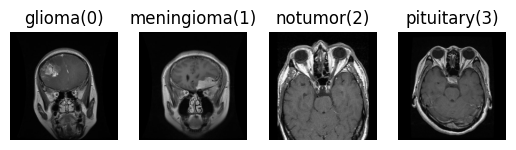

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Training/glioma/Tr-glTr_0000.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Training/meningioma/Tr-meTr_0000.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Training/notumor/Tr-noTr_0000.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Training/pituitary/Tr-piTr_0000.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

#Evaluation
The training process can be found here: https://github.com/mobarakol/AI_Medical_Imaging/blob/main/Active_Learning_Training_ReseNet.ipynb<br>

Download the pretrained weights:

In [7]:
!gdown 1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU

Downloading...
From: https://drive.google.com/uc?id=1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU
To: /content/best_model_4.pth.tar
100% 85.3M/85.3M [00:00<00:00, 201MB/s]


Evaluate the performance:

In [9]:
from torchvision import models
import torch

def evaluate(model, valid_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4
validloader = DataLoader(val_split, batch_size=128, shuffle=False, num_workers=2)

model = models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar'))
accuracy = evaluate(model, validloader)
print('accuracy:', accuracy)

<ipython-input-9-bfea860ae0cf>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_4.pth.tar'))


accuracy: 0.9641294838145232


#Evaluate Performance on new dataset:

Download new dataset

In [10]:
!gdown 1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
!unzip -q braintumor_v2.zip

Downloading...
From: https://drive.google.com/uc?id=1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
To: /content/braintumor_v2.zip
100% 25.6M/25.6M [00:00<00:00, 168MB/s]


Analysing new dataset:

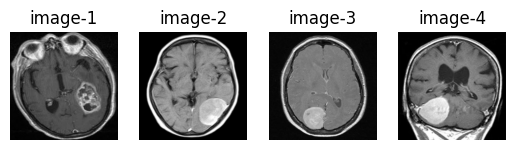

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['image-1', 'image-2', 'image-3', 'image-4']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0001.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0004.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor_v2/meningioma/Te-me_0010.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor_v2/meningioma/Te-me_0020.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

sample size of new dataset: 1311
Total dimension after t-SNE reduction: (1311, 2)


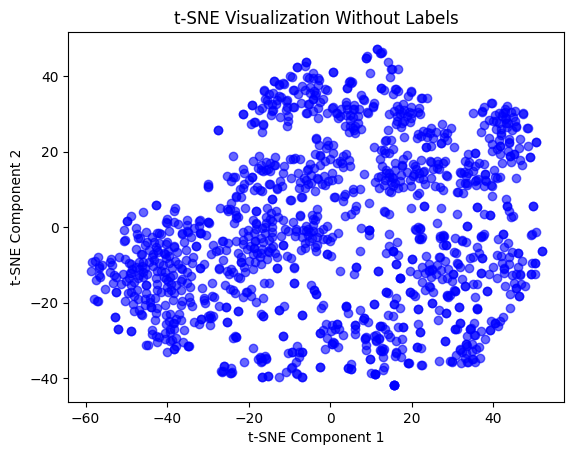

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))

img_all = []
for data, lab in new_dataset:
    img_all.append(np.array(data)[0,:,:])


img_all = np.array(img_all).reshape(len(new_dataset),28*28)

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# Plot without labels
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6, color='blue')  # Single color

ax.set_title('t-SNE Visualization Without Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.close()

Plot the images into 4 clusters:

sample size of new dataset: 1311


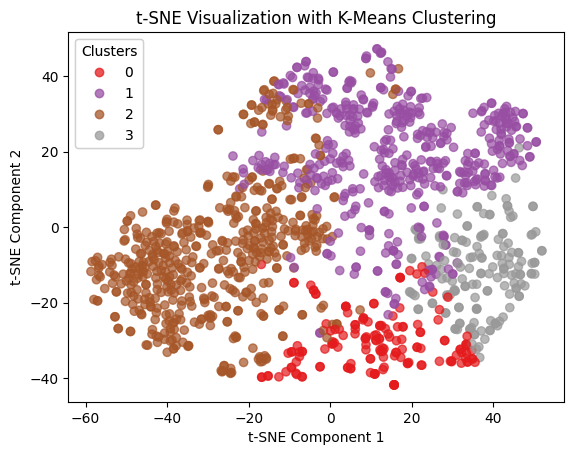

In [18]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))

img_all = []
for data, lab in new_dataset:
    img_all.append(np.array(data)[0,:,:])


img_all = np.array(img_all).reshape(len(new_dataset),28*28)

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

# Apply K-Means clustering to infer labels
num_clusters = 4  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(img_all)

# Plot with inferred cluster labels
fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='Set1', alpha=0.7)

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

ax.set_title('t-SNE Visualization with K-Means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.close()


In [ ]:


# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# Plot without labels
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6, color='blue')  # Single color

ax.set_title('t-SNE Visualization Without Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.close()


Evaluate on new dataset:

In [13]:
from torchvision import models
import torch

def evaluate(model, valid_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))
newdataloader = DataLoader(new_dataset, batch_size=128, shuffle=True, num_workers=2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4
model = models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar'))
accuracy = evaluate(model, newdataloader)
print('accuracy:', accuracy)

sample size of new dataset: 1311


<ipython-input-13-4493caa07a27>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_4.pth.tar'))


accuracy: 0.9511823035850496


In [3]:
import os
import sys
import argparse
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms


def get_arguments():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=1e-5, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=10, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=4, help='number classes')
    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args


def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

if __name__ == '__main__':
    args = get_arguments()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    trainloader = DataLoader(train_split, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(val_split, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    print('Training on:', device, 'train sample size:', len(train_split), 'test sample size:', len(val_split))

    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.999), weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    best_epoch, best_acc = 0.0, 0
    for epoch in range(args.num_epoch):
        train(model, trainloader, criterion, optimizer)
        accuracy = test(model, testloader)
        if accuracy > best_acc:
            patience = 0
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model_{}.pth.tar'.format(epoch))
        print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
                epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))


Training on: cuda train sample size: 5712 test sample size: 1311
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Download trained weights:

In [15]:
import gdown
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'best_model.pth.tar',quiet=True)

mkdir: cannot create directory ‘myweights’: File exists


'best_model.pth.tar'

Calculate Performance:

In [16]:
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

model = models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model.pth.tar'))
accuracy = test(model, testloader)
print(accuracy)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 194MB/s]
<ipython-input-16-ed724590543d>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

0.9877955758962624


In [ ]:
!gdown 1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
!unzip -q braintumor_v2.zip

In [13]:
from collections import Counter

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
]))
newdataloader = DataLoader(new_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
print('Training on:', device, 'train sample size:', len(new_dataset))
print(new_dataset.class_to_idx)

# Access the dataset class labels and their corresponding indices
class_to_idx = new_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Count class frequencies
class_counts = Counter([label for _, label in new_dataset.samples])

# Map counts back to class names
class_frequencies = {idx_to_class[idx]: count for idx, count in class_counts.items()}

# Print class frequencies
for class_name, count in class_frequencies.items():
    print(f"Class '{class_name}': {count} images")

Training on: cuda train sample size: 1311
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class 'glioma': 300 images
Class 'meningioma': 306 images
Class 'notumor': 405 images
Class 'pituitary': 300 images


Performance on new dataset:

In [18]:
accuracy = test(model, newdataloader)
print(accuracy)

0.9877955758962624


In [ ]:
import os
import sys
import argparse
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms


def get_arguments():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=10, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=4, help='number classes')
    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

if __name__ == '__main__':
    args = get_arguments()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    test_dataset = datasets.ImageFolder(root='/content/braintumor/Testing', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset))
    print(train_dataset.class_to_idx)

    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.999), weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    best_epoch, best_acc = 0.0, 0
    for epoch in range(args.num_epoch):
        train(model, trainloader, criterion, optimizer)
        accuracy = test(model, testloader)
        if accuracy > best_acc:
            patience = 0
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth.tar')
        print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
                epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))


Training on: cuda train sample size: 5712 test sample size: 1311
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


#Explainability:LIME

In [ ]:
!pip -q install lime

  Preparing metadata (setup.py) ... done


Download pretrained weights

In [ ]:
import gdown
!mkdir myweights
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

'myweights/best_model.pth.tar'

  0%|          | 0/1500 [00:00<?, ?it/s]

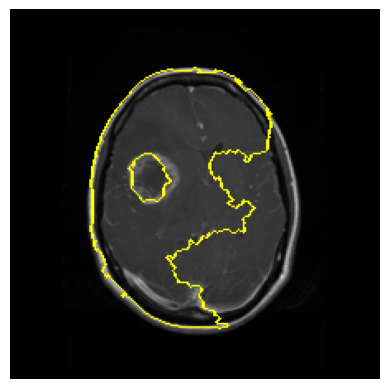

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries


def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model.pth.tar'))
model.eval()

img = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg')
# img = Image.open('/content/braintumor/Testing/glioma/Te-glTr_0007.jpg')
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=2,
                                         hide_color=0,
                                         num_samples=1500)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.axis('OFF');

(-0.5, 223.5, 223.5, -0.5)

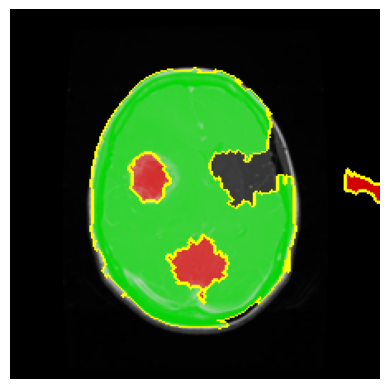

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.axis('OFF')

#Explainability:SHAP

In [ ]:
!pip -q install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.5 MB/s eta 0:00:00


Prepare data

In [ ]:
import numpy as np
import torch
import torchvision

# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)


In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import shap

def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output


class_names = list(test_dataset.class_to_idx.keys())
img0 = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg')
img1 = Image.open('/content/braintumor/Testing/glioma/Te-glTr_0007.jpg')
imgs = np.stack([np.array(img0), np.array(img1)])
Xtr = transform(torch.Tensor(imgs))
out = predict(Xtr)
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [0 0]: ['glioma' 'glioma']


Classes: [0 0]: ['glioma' 'glioma']


  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:28, 208.88s/it]              


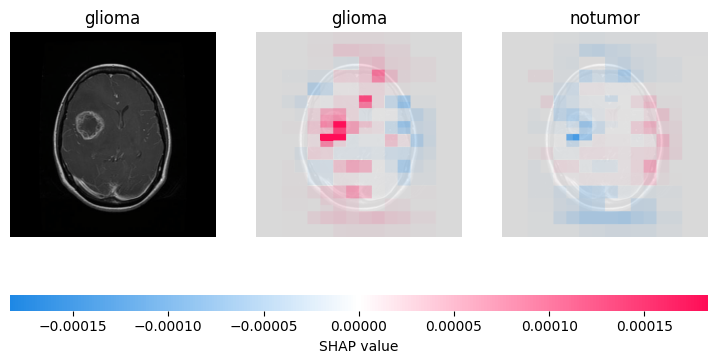

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
from PIL import Image

def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

topk = 2
batch_size = 50
n_evals = 10000
class_names = list(test_dataset.class_to_idx.keys())

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model.to(device)
model.load_state_dict(torch.load('/content/myweights/best_model.pth.tar'))
model.eval()


img0 = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg')
img1 = Image.open('/content/braintumor/Testing/glioma/Te-glTr_0007.jpg')
imgs = np.stack([np.array(img0), np.array(img1)])
Xtr = transform(torch.Tensor(imgs))
out = predict(Xtr)
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[0:1],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[0]],
)